# Met API Data Cleaning

In [1]:
import os
import pandas as pd
import re
from itertools import chain
from collections import Counter
import matplotlib.pyplot as plt

## Import Met JSON data

In [2]:
# Create DF from JSON file content

# Declare empty DF for concatenation
df_all = None

# Get files from data folder
base_dir = "../../data/met/api"
files = os.listdir(base_dir)

# Iterate over files
for file in files:
    
    # Convert each file to DF
    df = pd.read_json(f"{base_dir}/{file}")
    
    # Add first DF to concatenation DF
    if df_all is None:
        df_all = df
    
    # Concatenate remaining DFs
    else:
        df_all = pd.concat([df_all, df], axis="rows", ignore_index=True)
    

In [3]:
# Remove duplicates
met_df = df_all.drop_duplicates(subset=['objectID'], keep="first")

# Data Cleaning Part I: Geographic Data

### Import CSV of standardized countries and nationalities

In [4]:
# Generate standardized country DF from CSV for analysis
countries_df = pd.read_csv("../../data/standards/countries.csv")

In [5]:
# Strip whitespaces and convert standardized country data to lowercase

countries_df["Country"] = countries_df["Country"].str.strip().str.lower()

countries_df["Nationality"] = countries_df["Nationality"].str.strip().str.lower()

countries_df["Region"] = countries_df["Region"].str.strip().str.lower()

In [6]:
# Generate standard lists of countries, nationalities, and regions
# From standardized country DF for analysis

countries_list = countries_df.loc[:, "Country"].tolist()
nationalities_list = countries_df.loc[:, "Nationality"].tolist()
regions_list = countries_df.loc[:, "Region"].tolist()

### Create DF of Met Objects' Geographic Attributes for Data Cleaning Purposes

In [7]:
# Create temporary dataframe with geographic data
met_geo_df = met_df[["objectID", "country", "artistNationality", "culture", "region", "department"]]

## 'regions' Column

In [8]:
# Copy region column
met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\2587980422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region"]


### Stringify, Strip Whitespaces, & Convert to Lowercase

In [9]:
# Cast region copy column as strings
met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region_cc"].astype(str)

# Set region copy values to lowercase
met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of country copy values
met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

### Regex to clean region string values

In [10]:
# Create dictionary of regex substitutions
region_cc_sub_list = {
                       # Directional Words
                       r"(nor*th(?!\samerica)(?!\sireland)(?!\skorea)(?!\smacedonia)(east)*(west)*(ern)*)+": "",
                       r"(sou*th(?!\safrica)(?!\samerica)(?!\skorea)(?!\ssudan)(east)*(west)*(ern)*)+": "",
                       r"((?<![a-zA-Z])east(ern)*(?![a-zA-Z])+(?!\sdelta))": "",
                       r"(west(ern)*(?!\sdelta)(?!\smidlands))+": "",
                       r"(central(?!\safrican\srepublic)(?!\sdelta))+": "",
                       r"(coastal)+|(middle)+|(lower)+|(region)+|(upper)+": "",

                       # Descriptive Words
                       r"(\d+)+": "",
                       r"((nd.+)*(rd.+)*(th.+)*(st.+)*century)+": "",
                       r"(august)+": "",
                       r"(archipelago)+|(assembled(\sin)*)+": "",
                       r"(border)+": "",
                       r"(cast.+a)+|(country)+|(cover)+": "",
                       r"(elements)+": "",
                       r"(former(ly)*)+|((?<![a-zA-Z])from(?![a-zA-Z]))+": "",
                       r"(hardware)+|(hilt)+": "",
                       r"((?<![a-zA-Z])lid(?![a-zA-Z]))+|(la\st.ne\sii)+|((?<![a-zA-Z])leo(?![a-zA-Z]))+|(lisez.+immacul.e.)+": "",
                       r"((?<![a-zA-Z])made(\sin)*(?![a-zA-Z]))+|(modern(.day)*)+|(mounts)+": "",
                       r"((?<![a-zA-Z])now(?![a-zA-Z]))+": "",
                       r"(perhaps)+|(pos+ibly)+|(present(.day)*)+|(pro*bably)+": "",
                       r"(refurbished(\sin)*)+|(region)+|(repro)+": "",
                    
                       # Historical & Alternative Regional Spellings #
                       
                       # Africa
                       r"(cabinda)+": "angola",
                       r"(republic\sof\sbenin)+": "benin",
                       r"(upper\svolta)+": "burkina faso",
                       r"(republic\sof(\s)+cameroon)+": "cameroon",
                       r"(drc)+|(dem(\.\s)*(ocratic\s)*rep(\.\s)*(ublic\s)*(of\s)*(the\s)*congo)+|((?<!\sof\s)(?<!\sof\sthe\s)(the\s)*congo(?!,\srepublic\sof(\sthe)*)*)+|(zaire)+": "democratic republic of the congo",
                       r"(byzantine\segypt)+|(fayum(\sentrance)*(\sarea)*)+|(kharga(\soasis)*)+|(kush)+|(memphite)+|(sinai(\speninsula)*)+|(thebes)+": "egypt",
                       r"((kingdom\sof\s)*swaziland)+": "eswatini",
                       r"(kpandu)+": "ghana",
                       r"((republic\sof\s)*guinea.bissau)+": "guinea-bissau",
                       r"(republic\sof\sguinea(?!.bissau))+": "guinea",
                       r"(c.te\sd.ivoire)+": "ivory coast",
                       r"(republic\sof\skiribati)+": "kiribati",
                       r"(liberia-ivory\scoast)+": "liberia,ivory coast",
                       r"(republic\sof\smadagascar)+": "madagascar",
                       r"((the\s)*(?<!democratic\s)(?<!dem\.\s)republic\sof\s(the\s)*congo(,\srepublic\sof(\sthe)*)*)+": "republic of the congo",
                       r"((the\s)*senegambia)+": "senegal",
                       r"(nubia)+": "sudan",
                       r"((democratic\s)*(republic\sof\s)*timor-leste)+": "timor-leste",
                       r"(uganda-sudan)+": "uganda,sudan",

                       # Americas
                       r"(baffin\sisland)+|(belcher\sislands)+": "canada",
                       r"(republic\sof\scosta\srica)+": "costa rica",
                       r"(france\sguiana)+": "french guiana",
                       r"(suriname*)+": "suriname",
                       r"(unit+ed\sstates(\sof\samerica)*)+|(mid-atlantic(\sunited\sstates)*)+|(mid-*west(\sunited\sstates)*)+|(new\sbritain)+|(new\s*england(\sunited\sstates)*)+|((?<!north\s|south\s)american*)+|((?<![a-zA-Z])ny(?![a-zA-Z]))+|(u\.s\.(a\.)*(?!r\.)(?!s\.))+|((?<![a-zA-Z])usa*(?![a-zA-Z]))+": "united states",
                       r"(north american*)+": "canada, united states",
                       r"(new\sspain\s\(mexico\))+": "mexico",
                       r"(ica(\svalley)*)": "peru",

                       # Europe
                       r"(tirana)+|(uratru)+": "albania",
                       r"(vaspurakan)+": "armenia",
                       r"(austrian*s*)+": "austria",
                       r"((the\s)*balkans*)+": "balkans",
                       r"(brussels)+|(flanders)+|(flemish)+": "belgium",
                       r"(bosnia - herzegovina)+|(bosnia(?!.+herzegovina))+": "bosnia and herzegovina",
                       r"(bohemia)+|(czech(\srepublic)*(?!ia)(?!oslovakia))+": "czechia",
                       r"(czechoslovakia)+": "czechia, slovakia",
                       r"(danemark)+": "denmark",
                       r"(british(?!\sisles)(?!\svirgin\sislands))+|(engl(and)*(ish)*)+|(harold\scopping)+|(west\s+midlands)+|(yorkshire(\sand\sthe\shumber)*)+": "england,united kingdom",
                       r"(european)+": "europe",
                       r"((by\s)*french(\swoodworkers)*(?!\sguiana)(?!\spolynesia))+|(haute\sgaronne)+|(.le-de-france)+|(limoges)+|(paris)+|(pyr.n.es-aquintaine)": "france",
                       r"(alamania)+|(bavaria)+|(ger*mr*any*)+|(niederbreisig)+|(rhein)+|(saxony)+": "germany",
                       r"(germany\sof\sfrance)+": "germany,france",
                       r"(crete)+": "greece",
                       r"(carpathian\sbasin)+": "hungary",
                       r"(italian)+|(rome)+|(sardinia)+|(sicily)+|(trentino-alto\sadige)+": "italy",
                       r"(kosova)+": "kosovo",
                       r"(dutch)+|(friesland)+|(holland)+|((the\s)*netherland(er)*i*s*h*)+": "netherlands",
                       r"(northern\sireland(?!.+united\skingdom))+": "northern ireland,united kingdom",
                       r"(macedonia)+": "north macedonia",
                       r"(silesia)+": "poland",
                       r"((the\s)*iberian\speninsula)+": "portugal,spain",
                       r"(circassian*)+|(caucasus)+|((trans)*caucasian*)+|(dagestan)+|(russian*.federation)+|(u\.(s\.)+r\.)+|((?<![a-zA-Z])us+r(?![a-zA-Z]))+": "russia",
                       r"((?<![a-zA-Z])scot(ch)*(land)*(t*ish)*(?!.+united\skingdom))+": "scotland,united kingdom",
                       r"(spanish)+": "spain",
                       r"(gotland)+": "sweden",
                       r"((great\s)*britain)+|(u\.k\.)+|((?<![a-zA-Z])uk(?![a-zA-Z]))+": "united kingdom",
                       r"(wales(?!.+united\skingdom))+": "wales,united kingdom",
                       
                       # Asia
                       r"(bhut.n)+": "bhutan",
                       r"(chinese)+": "china",
                       r"(bidar)+|(deccan)+|(golconda)+|(india(al)*n*)+|(indus)+|(kashmir)+|(rajasthan)+|(sikkim)+": "india",
                       r"(celebes)+|(nusa\stenggara)+|(indonesian)+|(java)+|(sulawesi)+|(sumatra)+|(sumba(\sisland)*)+": "indonesia",
                       r"(safavid)+|(persian*)+": "iran",
                       r"(baghdad)+": "iraq",
                       r"(japanese)+": "japan",
                       r"(kirghiztan)+": "kyrgyzstan",
                       r"(malay(si)*a*n*(\speninsula)*)+|(sarawak)+": "malaysia",
                       r"((?<![a-zA-Z])burma*h*(ese)*)+": "myanmar",
                       r"(mindanao)+|((the\s)*(republic\sof\s(the\s)*)*phil+ip+ines*(\sislands)*)+": "philippines",
                       r"((old\scat\.\s)*(saudia*\s)*arabian*(\speninsula)*)+": "saudi arabia",
                       r"(jazira)+": "syria",
                       r"(siam)+": "thailand",
                       r"(anatolia)+|(byzantium)+|(constantinople)+|(nicomedia)+|(ottoman(\sempire)*)+": "turkey",
            
                       # Oceania
                       r"(mangareva)+": "french polynesia",
                       r"((republic\sof\s)*the\smarshall\sislands)+": "marshall islands",
                       r"federated\sstates\sof\smicronesia": "micronesia",
                       r"(aotearoa)+|(new\szealand\srotorua\swhakarewarewa)+": "new zealand",
                       r"republic\sof\spalau": "palau",
                       r"(murik\slakes)+|((?<!papua\s)new\sguinea)+|(prince\salexander\smountains)+|(washkuk(\shills)*)+": "papua new guinea",
                       r"((wallis\sand\s)*futuna(\sterritory)*)+": "wallis and futuna",
                       r"(wallis(?!\sand\sfutuna))+": "wallis and futuna",
                       
                       # Unknown
                       r"(unkn(own)*)+|(n\.a\.)+": "",

                       # Abbreviations
                       r"((?<![a-zA-Z])nw\.(?![a-zA-Z]))+|((?<![a-zA-Z])n\.(?![a-zA-Z]))+|((?<![a-zA-Z])s\.(?![a-zA-Z]))+|((?<![a-zA-Z])e\.(?![a-zA-Z]))+|((?<![a-zA-Z])w\.(?![a-zA-Z]))+": "",
                
                       # NAN
                       r"(^nan$)": "",
                       }

# Replace values
for key, value in region_cc_sub_list.items():
    met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region_cc"].apply(lambda x: re.sub(key, value, x))

In [11]:
# Strip country copy values again after regex substitutions
met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [12]:
# Split country copy values along regex delimiters
met_geo_df.loc[:, "region_cc"] = met_geo_df.loc[:, "region_cc"].apply(
    # Avoid matching special cases in country names
    lambda x: re.split(r",+|\.+|;+|\:+|\?+|/+|–+|\[+|\]+|\(+|\)+|(?<![a-zA-Z])or(?![a-zA-Z])+|&(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)+|(?<![a-zA-Z])and(?![a-zA-Z])(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)", 
                       x))


In [13]:
# Strip whitespaces from each word in culture copy list
# Filter culture list by standardized list of nationalities

# Create nested list of country copy values
region_cc_temp = met_geo_df.loc[:, "region_cc"]

# Create empty list for appending filtered values
region_cc2_list = []

# Iterate over nested nationality copy list
for i, cc1 in enumerate(region_cc_temp):
    if cc1 != [""]:
        # Strip whitespaces from each item in list
        cc1_strip = list(set([cw.strip().strip('-').strip() for cw in cc1 if cw != ""]))

        # Filter items that match items in standardized country and nationality lists
        cc1_ftemp = cc1_strip
        
       # Substitute country names for nationalities
        for ct in cc1_ftemp:
            if ct in nationalities_list:
                # Get index of country name in standardized list
                j = nationalities_list.index(ct)
                
                # Get matching nationality at that index in 2nd standardized list
                ctry_temp = countries_list[j]

                # Remove country name from filtered list
                cc1_strip.remove(ct)

                # Add matching nationality to filtered list if not already present
                if ctry_temp not in cc1_strip:
                    cc1_strip.append(ctry_temp)

        # Append filtered list to nested list
        region_cc2_list.append(cc1_strip)
            
    # Append list with empty string if original list was also empty
    else:
        region_cc2_list.append([""])
# View unique country values to monitor progress

# Flatten nested list of country copy lists
working_regions_list = list(chain.from_iterable(region_cc2_list))

# Count instances of each unique value
count_unique_regions = Counter(working_regions_list).most_common()

# print values & counts
print(f"Unique region values (countries subbed): {len(count_unique_regions)}")
print()
for key, value in count_unique_regions:
    print(f"{key} - {value}")

Unique region values (countries subbed): 503

 - 444420
egypt - 18794
united states - 6934
iran - 2551
mesopotamia - 2347
mesounited states - 1276
eastern delta - 562
syria - 483
england - 471
united kingdom - 470
indonesia - 446
turkey - 397
mid - 361
levant - 341
asia - 319
france - 253
ivory coast - 237
india - 224
bactria-margiana - 224
papua new guinea - 210
luristan - 184
peru - 182
coast - 178
russia - 162
sudan - 143
desert - 132
cyprus - 131
borneo - 129
canada - 108
mid united states - 85
grassfields - 77
afrperu - 71
islamic lands - 61
czechia - 57
ern delta - 47
philippines - 44
caribbean - 41
balkans peninsula - 39
black sea - 32
highlands - 30
eurasian steppes - 28
central delta - 27
urartu - 26
caspian - 25
cameroon - 21
timor island - 21
afghanistan - 20
khurasan - 18
diquis - 16
new ireland - 15
teke - 15
kimberley - 14
caribbean lowlands - 14
caroline islands - 14
saudi arabia - 13
tibet - 12
guinea coast - 12
punjab - 12
churunga valley - 11
visayas - 11
shahsevan tr

In [14]:
# Create nested list of cultures that match standardized list
region_cc_final = []

for rg in region_cc2_list:
    if rg != [""]:
        # Filter only items that match standardized nationalities list
        standard_region_filter = list(set([r for r in rg if (r in countries_list or r in nationalities_list)]))
        region_cc_final.append(standard_region_filter)
    else:
        region_cc_final.append([""])

In [15]:
# Flatten nested list of country copy lists
working_regions_final = list(chain.from_iterable(region_cc_final))

# Create dictionary of unique country values and respective counts
final_unique_regions = Counter(working_regions_final).most_common()

# Print dictionary length
print(f"Unique region values (standardized): {len(final_unique_regions)}")
print()

# Pring values & counts
for key, value in final_unique_regions:
    print(f"{key} - {value}")

Unique region values (standardized): 54

 - 444415
egypt - 18794
united states - 6934
iran - 2551
syria - 483
united kingdom - 470
indonesia - 446
turkey - 397
france - 253
ivory coast - 237
india - 224
papua new guinea - 210
peru - 182
russia - 162
sudan - 143
cyprus - 131
canada - 108
philippines - 44
cameroon - 21
afghanistan - 20
saudi arabia - 13
tibet - 12
democratic republic of the congo - 9
lebanon - 9
italy - 8
spain - 7
portugal - 7
angola - 7
cook islands - 5
greece - 5
belgium - 3
burkina faso - 3
germany - 2
argentina - 2
guinea - 2
ghana - 2
austria - 2
algeria - 1
benin - 1
zambia - 1
australia - 1
mali - 1
mozambique - 1
zimbabwe - 1
greenland - 1
mexico - 1
ukraine - 1
mongolia - 1
azerbaijan - 1
pakistan - 1
norway - 1
malaysia - 1
china - 1
senegal - 1


## 'culture' Column

In [16]:
# Copy culture column
met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\3758892128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture"]


### Stringify, Strip Whitespaces, & Convert to Lowercase

In [17]:
# Cast culture copy column as strings
met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture_cc"].astype(str)

# Set culture copy values to lowercase
met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of culture copy values
met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [18]:
# Create dictionary of regex substitutions
culture_cc_sub_list = {
                       # Directional Words
                       r"(nor*th(?!\samerican*)(?!\skorean*)(?!\smacedonian*)(east)*(west)*(ern)*(?!\sireland)(?!\sirish))+": "",
                       r"(sou*th(?!\safrican*)(?!\samerican*)(?!\skorean*)(?!\ssudan(ese)*)(east)*(west)*(ern)*)+": "",
                       r"((?<![a-zA-Z])east(ern)*(?![a-zA-Z]))+": "",
                       r"(west(ern)*(\scoast)*)+": "",
                       r"(central(?!\safrican\srepublic))+": "",
                       r"(lower)+|(coastal)+|(region)+": "",

                       # Descriptive Words

                       r"(\d+)+": "",
                       r"((nd.+)*(rd.+)*(th.+)*(st.+)*century)+": "",
                       r"((?<![a-zA-Z])active(\sin)*(?![a-zA-Z]))+|(after)+|(ancient)+|(assyro)+": "",
                       r"(blade)+|((?<![a-zA-Z])born(\sin)*(?![a-zA-Z]))+": "",
                       r"(countr*y)+": "",
                       r"(duchy\sof\s)": "",
                       r"((?<![a-zA-Z])(early\s)*s(?![a-zA-Z]))+|(empire)+|(export(ed)*(.+by)*)+": "",
                       r"(fabric)+|(family)+|(former(ly)*)+|(?<![a-zA-Z])(found(ed)*(\sin)*(\snear)*)+|((?<![a-zA-Z])from(?![a-zA-Z]))+|((?<![a-zA-Z])for(?![a-zA-Z]))+": "",
                       r"(kingdom.*of)+": "",
                       r"((?<![a-zA-Z])late(?![a-zA-Z]))+|(likely)+": "",
                       r"(made(\sin)*)+|(manufactured*r*(\sin)*)+|(market)+|(middle)+|(modern(.*day)*)+": "",
                       r"((?<!first\s)nation(al)*)+|(naturalized)+|((?<![a-zA-Z])neo(?![a-zA-Z]))+|((?<![a-zA-Z])now(?![a-zA-Z]))+": "",
                       r"(peoples*)+|(perhaps)+|(pos+ibly)+|(present(.day)*)+|(pro*bably)+": "",
                       r"(region(\sof)*)+": "",
                       r"(stuttgart.+rttemberg)+": "",
                       r"(unidentified.*sub.*school)+": "",
                       r"(vicinity(\sof)*)+": "",
                    
                       # Historical & Alternative Regional Spellings #
                       
                       # Africa
                       r"(((democratic.+)*republic.+of.+)*congo(?!lese))+|(kongo)+": "congolese",
                       r"(coptic)+": "egyptian",
                       r"(dogon)+": "mali",
                                           
                       # Americas
                       r"(north.america)+|(new.york)+|(shaker(s)*)": "american",
                       r"(maya(?!n))+": "mayan",
                       r"(aztec)+|(mezcala(n)*)+": "mexican",
                       r"(chimú)+|(inca(n)*)+|(moche)+|(paracas)+|(wari)+": "peruvian",
                   
                       # Europe
                       r"(flemish)+": "belgian",                 
                       r"(london)+": "british",
                       r"(bohemia(n)*)+|(czech.republic)+": "czech",
                       r"(friesland)+|(holland)+|((the\s)*nethe*rland(er)*i*s*h*)+": "dutch",
                       r"(frankish)+|(paris)+": "french",
                       r"(augsburg)+|(nuremberg)+|(saxony)+": "german",
                       r"(attic)+|(boeotian)+|(corinth(ian)*)+|(crete)+|(cretan)+|(laconian)+|(minoan)+|(mycenaean)+": "greek",
                       r"(apulia(n)*)+|(aymara(n)*)+|(campanian)+|(chancay)+|(etruscan)+|(italic)+|(milan(ian)*)+|((?<![a-zA-Z])roman(?![a-zA-Z]))+|((?<![a-zA-Z])rome(?![a-zA-Z]))+|(tarentine)+|(venice)+|(venetian)+": "italian",
                       r"(catalan)+": "spanish",
                       
                       # Asia
                       r"(asia(?!n))": "asian",
                       r"(burma)+": "burmese",
                       r"(xinjiang.*autonomous)+": "chinese",
                       r"(phil+ip+ines*)+": "filipino",
                       r"(japan(?!ese))+": "japanese",
                       r"(bengal)+|(calcutta)+|(gujarat(?!i))+|(kashmir)+|(rajasthan(?!i))+|(tamil.nadu)+": "indian",
                       r"(asmat)+|(java(nese)*)+": "indonesian",
                       r"(assyria(n)*)+|(babylon(ian)*)+|(old.iraqi.trading.colony)+|(sumerian)+": "iraqi",
                       r"(achaemenid)+|(parthian)+|(persia(n)*)+|(sas+anian)+": "iranian",
                       r"(korea(?!n))+": "korean",
                       r"(kathmandu.+valley)+": "nepalese",
                       r"((of.+)*gandhara(n)*)+": "pakistani",
                       r"(sri.lanka(?!n))+": "sri lankan",
                       r"(byzantine)+|(lydia(n)*)+|(sardis)+": "turkish",
            
                       # Oceania
                       r"(kwoma)+": "papua",
                     
                       # Unknown
                       r"(unkn(own)*)+|(n\.a\.)+": "",

                       # NAN
                       r"(^nan$)+": "",
                       }

# Replace values
for key, value in culture_cc_sub_list.items():
    met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture_cc"].apply(lambda x: re.sub(key, value, x))

In [19]:
# Strip country copy values again after regex substitutions
met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [20]:
# Split country copy values along regex delimiters
met_geo_df.loc[:, "culture_cc"] = met_geo_df.loc[:, "culture_cc"].apply(
    # Avoid matching special cases in country names
    lambda x: re.split(r",+|\.+|;+|\:+|\?+|/+|–+|\[+|\]+|\(+|\)+|(?<![a-zA-Z])or(?![a-zA-Z])+|&(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)+|(?<![a-zA-Z])and(?![a-zA-Z])(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)", 
                       x))


In [21]:
# Strip whitespaces from each word in culture copy list
# Filter culture list by standardized list of nationalities

# Create nested list of country copy values
culture_cc_temp = met_geo_df.loc[:, "culture_cc"]

# Create empty list for appending filtered values
culture_cc2_list = []

# Iterate over nested nationality copy list
for i, cc1 in enumerate(culture_cc_temp):
    if cc1 != [""]:
        # Strip whitespaces from each item in list
        cc1_strip = list(set([cw.strip().strip('-').strip() for cw in cc1 if cw != ""]))

        # Filter items that match items in standardized country and nationality lists
        cc1_ftemp = cc1_strip
        
        # Substitute nationalities for country names
        for ct in cc1_ftemp:
            if ct in countries_list:
                # Get index of country name in standardized list
                j = countries_list.index(ct)
                
                # Get matching nationality at that index in 2nd standardized list
                natl_temp = nationalities_list[j]

                # Remove country name from filtered list
                cc1_strip.remove(ct)

                # Add matching nationality to filtered list if not already present
                if natl_temp not in cc1_strip:
                    cc1_strip.append(natl_temp)

        # Append filtered list to nested list
        culture_cc2_list.append(cc1_strip)
            
    # Append list with empty string if original list was also empty
    else:
        culture_cc2_list.append([""])
# View unique country values to monitor progress

# Flatten nested list of country copy lists
working_cultures_list = list(chain.from_iterable(culture_cc2_list))

# Count instances of each unique value
count_unique_cultures = Counter(working_cultures_list).most_common()

# print values & counts
print(f"Unique culture values (countries subbed): {len(count_unique_cultures)}")
print()
for key, value in count_unique_cultures:
    print(f"{key} - {value}")

Unique culture values (countries subbed): 2842

 - 318543
american - 32454
japanese - 23140
greek - 21989
chinese - 15469
french - 12883
italian - 12605
european - 4640
british - 3974
german - 3231
cypriot - 3137
iranian - 2867
indian - 2681
peruvian - 2535
indonesian - 2309
egyptian - 1960
spanish - 1423
iraqi - 1280
turkish - 1199
mexican - 1168
dutch - 835
thai - 705
korean - 666
tibetan - 562
coast - 542
native american - 481
austrian - 480
belgian - 389
pakistani - 369
russian - 327
papua - 303
mediterranean - 270
nepalese - 260
yoruba - 260
filipino - 256
swiss - 254
african - 231
asian - 224
vicú - 223
bactria-margiana archaeological complex - 222
inuit - 205
vietnamese - 203
irish - 195
kuba - 193
nasca - 193
edo - 188
burmese - 183
malian - 178
islamic - 172
old iraqi trading colony - 170
syrian - 160
congolese - 140
mayan - 135
cambodian - 131
czech - 128
cheyenne - 119
fon - 114
hilt - 112
sri lankan - 110
colombian - 107
costa rican - 107
baule - 102
senufo - 98
toba batak 

In [22]:
# Create nested list of cultures that match standardized list
culture_cc_final = []

for cu in culture_cc2_list:
    if cu != [""]:
        # Filter only items that match standardized nationalities list
        natl_filter = list(set([c for c in cu if c in nationalities_list]))
        culture_cc_final.append(natl_filter)
    else:
        culture_cc_final.append([""])

In [23]:
# Flatten nested list of country copy lists
working_cultures_final = list(chain.from_iterable(culture_cc_final))

# Create dictionary of unique country values and respective counts
final_unique_cultures = Counter(working_cultures_final).most_common()

# Print dictionary length
print(f"Unique culture values (standardized): {len(final_unique_cultures)}")
print()

# Pring values & counts
for key, value in final_unique_cultures:
    print(f"{key} - {value}")

Unique culture values (standardized): 138

 - 318123
american - 32454
japanese - 23140
greek - 21989
chinese - 15469
french - 12883
italian - 12605
british - 3974
german - 3231
cypriot - 3137
iranian - 2867
indian - 2681
peruvian - 2535
indonesian - 2309
egyptian - 1960
spanish - 1423
iraqi - 1280
turkish - 1199
mexican - 1168
dutch - 835
thai - 705
korean - 666
tibetan - 562
austrian - 480
belgian - 389
pakistani - 369
russian - 327
nepalese - 260
filipino - 256
swiss - 254
vietnamese - 203
irish - 195
burmese - 183
malian - 178
syrian - 160
congolese - 140
cambodian - 131
czech - 128
sri lankan - 110
colombian - 107
costa rican - 107
moroccan - 82
hungarian - 81
afghan - 80
mongolian - 70
romanian - 62
cameroonian - 60
swedish - 54
fijian - 52
guatemalan - 51
bolivian - 51
danish - 48
portuguese - 44
algerian - 44
norwegian - 41
nigerian - 37
albanian - 36
croatian - 35
solomon islander - 35
canadian - 34
brazilian - 34
vanuatuan - 33
bhutanese - 32
panamanian - 31
macedonian - 28
po

## 'artistNationality' Column
### Clean, Standardize, & Map Values to Filtered 'country' Column

Each subsequent column in met_geo_df will be cleaned and used to fill in missing values from other columns containing geographic information.

A similar cleaning pattern will be used on each geographic column.

In [24]:
# Copy artist nationality column
met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artistNationality"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\208386428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artistNationality"]


### Stringify, Strip Whitespaces, & Convert to Lowercase

In [25]:
# Cast artist nationality copy column as strings
met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artist_natl_cc"].astype(str)

# Set artist nationality copy values to lowercase
met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artist_natl_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of artist nationality copy values
met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artist_natl_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [26]:
# Create dictionary of regex substitutions
natl_cc_sub_list = {
                       # Directional Words
                       r"(nor*th(?!\samerican*)(?!\skorean*)(?!\smacedonian*)(east)*(west)*(ern)*(?!\sireland)(?!\sirish))+": "",
                       r"(sou*th(?!\safrican*)(?!\samerican*)(?!\skorean*)(?!\ssudan(ese)*)(east)*(west)*(ern)*)+": "",
                       r"((?<![a-zA-Z])east(ern)*(?![a-zA-Z]))+": "",
                       r"(west(ern)*(\scoast)*)+": "",
                       r"(central(?!\safrican\srepublic))+": "",
                       r"(lower)+|(coastal)+|(region)+": "",

                       # Descriptive Words

                       r"(\d+)+": "",
                       r"((nd.+)*(rd.+)*(th.+)*(st.+)*century)+": "",
                       r"((?<![a-zA-Z])active(\sin)*(?![a-zA-Z]))+": "",
                       r"(ancient)+": "",
                       r"((?<![a-zA-Z])born(\sin)*(?![a-zA-Z]))+": "",
                       r"(countr*y)+": "",
                       r"(duchy\sof\s)": "",
                       r"((?<![a-zA-Z])(early\s)*s(?![a-zA-Z]))+|(empire)+": "",
                       r"(family)+|(former(ly)*)+|(founded(\sin)*)+": "",
                       r"(manufactured*r*(\sin)*)+|(middle)+|(modern(.+day)*)+": "",
                       r"((?<!first\s)nation(al)*)+|(naturalized)+|((?<![a-zA-Z])now(?![a-zA-Z]))+": "",
                       r"(peoples*)+|(perhaps)+|(pos+ibly)+|(present(.day)*)+|(pro*bably)+": "",
                       r"(stuttgart.+rttemberg)": "",
                    
                       # Historical & Alternative Regional Spellings #
                       
                       # Africa
                       r"(africa(?!n))+": "african",
                       r"(african\W)": "african,",
                       r"(algiers)": "algerian",
                       r"((republic\sof\s)*cameroon(?!ian))+": "cameroonian",
                       r"(drc)+|((dem)*(\.\s)*(ocratic\s)*rep(\.\s)*(ublic\s)*(of\s)*(the\s)*congo)+|((?<!\sof\s)(?<!\sof\sthe\s)(the\s)*congo(?!lese))+|(zaire)+": "congolese",
                       r"(ethiopian\W)+": "ethiopian,",
                       r"(mosan)+": "nigeria",
                       r"(tunesian*)+": "tunisian",
                       
                       # Americas
                       r"(-american)+": ",american",
                       r"(america(ns)*(?!n$)(?!n\W+))+|(californian*)+|(chicago)+|(mendocino)+|(morgantown)+|(new\syork)+|(philadelphia)+|(virginia)+|((?<![a-zA-Z])usa*(?![a-zA-Z]))+": "american",
                       r"(american\W(?!indian)(?!samoan*))+": "american,",
                       r"(american\Windians*)+|(first\Wnations*)+": "native american",
                       r"(argentine)+": "argentinian",
                       r"(citizen.+oklahoma)+": "cherokee",
                       r"(chiricahua\sapache\snative\samerican)+": "chiricahua,apache",
                       r"(greenlandish)+": "greenlandic",
                       r"(greenlandic\W)+": "greenlandic,",
                       r"(mexican\W)+": "mexican,",
                       r"(og\sla\sla)+": "oglala",
                       r"(parayguayan)+": "paraguayan",

                       # Europe
                       r"(tyrolean)+": "austrian",
                       r"(austro\W)+": "austrian,",
                       r"(belarussian)+": "belarusian",
                       r"(brabant)+|(diest)+|(flemish)+|(ghent)+|(leuven)+": "belgian",
                       r"(anglo)+|((great\s)*britain)+|(engl(and)*(ish)*)+|(london)+": "british",
                       r"(british\W)+": "british,",
                       r"(bosnian*(.+herzegovinan*)*(?!\sand\sherzegovinan))+": "bosnian and herzegovinan",
                       r"((?<!bosnian\sand\s)(bosnia.+)*herzegovinan*)+": "bosnian and herzegovinan",
                       r"(roznau.+austria-hungary\])+|(bohemian*)+|(moravian*)+": "czech",
                       r"(czechoslovakian*)+": "czechia,slovakia",
                       r"(danish\W)+": "danish,",
                       r"(friesland)+|(holland)+|((the\s)*nethe*rland(er)*i*s*h*)+": "dutch",
                       r"(finish)+": "finnish",
                       r"(corsican*)+|(limoges)+|(paris(ian)*)+": "french",
                       r"(franco\W)+|(french\W(?!guiana*n*(ese)*)(?!polynesian*))+": "french,",
                       r"((upper\W)*rhine)+": "french,german,swiss",
                       r"(europe(?!an))+": "european",
                       r"(aachen)+|(alsatian)+|(augsburg)+|(bremen)+|(federal\srepublic\sof\sgermany*)+|(ger*mr*any*)+|((kingdom\sof\s)*prussian*)+|(koblenz)+|(han+over(ian)*)+|(lombard(?!y))+|(nuremberg)+|(solingen)+|(strassburg)+|(stuttgart)+": "german",
                       r"(german\W)+": "german,",
                       r"(anconan*)+|(bologna*(ese)*)+|(brescian*)+|(emilian*)+|(floren(ce)*(tine)*)+|(milan)+|(naples)+|(pavia)+|((?<![a-zA-Z])rom(an)*e*(?![a-zA-Z]))+|(siena)+|(sienese)+|(tuscany*)+|(varese)+|(venice)+|(venetian)+|(veronese)+": "italian",
                       r"(lithunanian)+": "lithuanian",
                       r"((?<!north\s)macedonian*)+": "north macedonian",
                       r"((?<![a-zA-Z])heim(?![a-zA-Z]))+": "norwegian",
                       r"(cieszyn)+|(pomeranian*)+|(silesian)+": "polish",
                       r"(polish\W)+": "polish,",
                       r"(rumani(an)*)+|(transylvanian*)+": "romanian",
                       r"((?<![a-zA-Z])perm(?![a-zA-Z]))+|(soviet)+|((?<![a-zA-Z])us+r(?![a-zA-Z]))+": "russian",
                       r"((?<![a-zA-Z])scot(ch)*(land)*(t*ish)*(?!.+british))+": "scottish,british",
                       r"(serbo-croat)+": "serbian,croatian",
                       r"((?<![a-zA-Z])slovaki*(?![a-zA-Z]))+": "slovakian",
                       r"(incheon)+": "south korean",
                       r"(andalusian*)+|(catalan)+|(spainish)+": "spanish",
                       r"(swiss\W)+": "swiss,",
                       r"(wales(?!.+british))+|(welsh(?!.+british))+": "welsh,british",
                       r"(yugoslavia(?!n))+": "yugoslavian",
                       
                       # Asia
                       r"(afghani(?!stan))+": "afghan",
                       r"(bangladesh(?!i))+": "bangladeshi",
                       r"(manchu)+": "chinese",
                       r"(kashmiri*)+": "indian",
                       r"(persian*)": "iranian",
                       r"(iranian\W)+": "iranian,",
                       r"(assyrian*)+": "iranian,iraqi,syrian,turkish",
                       r"((?<![a-zA-Z])iban(?![a-zA-Z]))+": "malaysian",
                       r"(korea(?!n))+": "korean",
                       r"(byzantine)+|(istanbul)+|(ottoman(\Wturk(ey)*(ish)*)*)+": "turkish",
                       r"(turkish\W)+": "turkish,",
                       r"(uzbek(?!istani*))+": "uzbekistani",
                       r"(yemini)+": "yemeni",
            
                       # Oceania
                       r"(papaua)+": "papua",
                     
                       # Unknown
                       r"(unkn(own)*)+|(n\.a\.)+": "",

                       # NAN
                       r"(^nan$)+": "",
                       }

# Replace values
for key, value in natl_cc_sub_list.items():
    met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artist_natl_cc"].apply(lambda x: re.sub(key, value, x))

In [27]:
# Strip country copy values again after regex substitutions
met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artist_natl_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [28]:
# Split country copy values along regex delimiters
met_geo_df.loc[:, "artist_natl_cc"] = met_geo_df.loc[:, "artist_natl_cc"].apply(
    # Avoid matching special cases in country names
    lambda x: re.split(r",+|\.+|;+|\:+|\?+|/+|–+|\[+|\]+|\(+|\)+|(?<![a-zA-Z])or(?![a-zA-Z])+|&(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)+|(?<![a-zA-Z])and(?![a-zA-Z])(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)", 
                       x))

In [29]:
# Strip whitespaces from each word in nationality copy list
# Filter list by standardized list of nationalities

# Create nested list of country copy values
natl_cc_temp = met_geo_df.loc[:, "artist_natl_cc"]

# Create empty list for appending filtered values
natl_cc2_list = []

# Iterate over nested nationality copy list
for i, cc1 in enumerate(natl_cc_temp):
    if cc1 != [""]:
        # Strip whitespaces from each item in list
        cc1_strip = list(set([cw.strip().strip('-').strip() for cw in cc1 if cw != ""]))

        # Filter items that match items in standardized country and nationality lists
        cc1_ftemp = cc1_strip
        
        # Substitute nationalities for country names
        for ct in cc1_ftemp:
            if ct in countries_list:
                # Get index of country name in standardized list
                j = countries_list.index(ct)
                
                # Get matching nationality at that index in 2nd standardized list
                natl_temp = nationalities_list[j]

                # Remove country name from filtered list
                cc1_strip.remove(ct)

                # Add matching nationality to filtered list if not already present
                if natl_temp not in cc1_strip:
                    cc1_strip.append(natl_temp)

        # Append filtered list to nested list
        natl_cc2_list.append(cc1_strip)
            
    # Append list with empty string if original list was also empty
    else:
        natl_cc2_list.append([""])

In [30]:
# View unique country values to monitor progress

# Flatten nested list of country copy lists
working_nationalities_list = list(chain.from_iterable(natl_cc2_list))

# Count instances of each unique value
count_unique_nationalities = Counter(working_nationalities_list).most_common()

# print values & counts
print(len(count_unique_nationalities))
print()
for key, value in count_unique_nationalities:
    print(f"{key} - {value}")

### OPTIONAL VIEW ###
# Display country copy lists with more than one item
# print()
# for ct in country_cc2_list:
#     if len(ct) > 1:
#         print(ct)

182

 - 234788
american - 97508
french - 49521
british - 29691
italian - 25025
german - 14518
dutch - 10152
japanese - 7697
scottish - 2720
austrian - 2645
spanish - 2378
chinese - 2150
mexican - 2138
belgian - 2091
swiss - 1552
czech - 1528
russian - 1488
irish - 1053
hungarian - 734
swedish - 694
iranian - 652
indian - 630
canadian - 601
danish - 547
polish - 438
greek - 312
cuban - 265
australian - 225
slovakian - 214
czechia - 208
finnish - 200
lithuanian - 194
ukrainian - 185
welsh - 173
norwegian - 154
luxembourgish - 137
native american - 136
israeli - 114
argentinian - 105
austria-hungary - 104
armenian - 104
romanian - 101
egyptian - 82
european - 80
korean - 72
brazilian - 66
turkish - 64
south african - 63
uruguayan - 61
portuguese - 61
peruvian - 58
tunisian - 50
malian - 48
african - 48
latvian - 45
nigerian - 43
bulgarian - 39
lebanese - 31
colombian - 31
pakistani - 30
algerian - 26
chilean - 26
icelandic - 26
togolese - 25
croatian - 23
venezuelan - 23
papuan - 22
haiti

In [31]:
# Create nested list of nationality names that match standardized list
artist_natl_final = []

for natl in natl_cc2_list:
    if natl != [""]:
        # Filter only items that match standardized nationalities list
        natl_filter = list(set([n for n in natl if n in nationalities_list]))
        artist_natl_final.append(natl_filter)
    else:
        artist_natl_final.append([""])

In [32]:
# Flatten nested list of country copy lists
working_nationalities_final = list(chain.from_iterable(artist_natl_final))

# Create dictionary of unique country values and respective counts
final_unique_nationalities = Counter(working_nationalities_final).most_common()

# Print dictionary length
print(len(final_unique_nationalities))
print()

# Pring values & counts
for key, value in final_unique_nationalities:
    print(f"{key} - {value}")

121

 - 234786
american - 97508
french - 49521
british - 29691
italian - 25025
german - 14518
dutch - 10152
japanese - 7697
austrian - 2645
spanish - 2378
chinese - 2150
mexican - 2138
belgian - 2091
swiss - 1552
czech - 1528
russian - 1488
irish - 1053
hungarian - 734
swedish - 694
iranian - 652
indian - 630
canadian - 601
danish - 547
polish - 438
greek - 312
cuban - 265
australian - 225
slovakian - 214
finnish - 200
lithuanian - 194
ukrainian - 185
norwegian - 154
luxembourgish - 137
israeli - 114
argentinian - 105
armenian - 104
romanian - 101
egyptian - 82
korean - 72
brazilian - 66
turkish - 64
south african - 63
uruguayan - 61
portuguese - 61
peruvian - 58
tunisian - 50
malian - 48
latvian - 45
nigerian - 43
bulgarian - 39
lebanese - 31
colombian - 31
pakistani - 30
algerian - 26
chilean - 26
icelandic - 26
croatian - 23
venezuelan - 23
papuan - 22
haitian - 19
new zealander - 18
moroccan - 14
puerto rican - 13
ethiopian - 13
sri lankan - 13
burkinabe - 11
dominican - 10
panaman

## 'country' Column
### Standardize Values

In some cases, more than one spelling variation refers to the same country or region in the dataframe. In other cases, a row contains more than one value in the 'country' column.  

This cleaning process utilizes a separate list of modern country names along with regular expressions to standardize values in this column while preserving as much accurate geographic data as possible. 

Occassionally, historical and/or regional names such as "europe" and "gaul" have been retained for cleaning related columns such as "culture," "region," and "subregion."

In [33]:
# Copy country column
met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\2744780342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country"]


### Stringify, Strip Whitespaces, & Convert to Lowercase

In [34]:
# Cast country copy column as strings
met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country_cc"].astype(str)

# Set country copy values to lowercase
met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of country copy values
met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

### Filter values using regex

In [35]:
# Create dictionary of regex substitutions
country_cc_sub_list = {
                       # Directional Words
                       r"(nor*th(?!\samerica)(?!\sireland)(?!\skorea)(?!\smacedonia)(east)*(west)*(ern)*)+": "",
                       r"(sou*th(?!\safrica)(?!\samerica)(?!\skorea)(?!\ssudan)(east)*(west)*(ern)*)+": "",
                       r"((?<![a-zA-Z])east(ern)*(?![a-zA-Z])+(?!\sdelta))": "",
                       r"(west(ern)*(?!\sdelta))+": "",
                       r"(central(?!\safrican\srepublic)(?!\sdelta))+": "",
                       r"(lower)+|(coastal)+|(region)+": "",

                       # Descriptive Words
                       r"(\d+)+": "",
                       r"((nd.+)*(rd.+)*(th.+)*(st.+)*century)+": "",
                       r"(august)+": "",
                       r"(archipelago)+|(assembled(\sin)*)+": "",
                       r"(border)+": "",
                       r"(cast.+a)+|(country)+|(cover)+": "",
                       r"(elements)+": "",
                       r"(former(ly)*)+|((?<![a-zA-Z])from(?![a-zA-Z]))+": "",
                       r"(hardware)+|(hilt)+": "",
                       r"((?<![a-zA-Z])lid(?![a-zA-Z]))+|(la\st.ne\sii)+|((?<![a-zA-Z])leo(?![a-zA-Z]))+|(lisez.+immacul.e.)+": "",
                       r"((?<![a-zA-Z])made(\sin)*(?![a-zA-Z]))+|(modern(.day)*)+|(mounts)+": "",
                       r"((?<![a-zA-Z])now(?![a-zA-Z]))+": "",
                       r"(perhaps)+|(pos+ibly)+|(present(.day)*)+|(pro*bably)+": "",
                       r"(refurbished(\sin)*)+|(region)+|(repro)+": "",
                    
                       # Historical & Alternative Regional Spellings #
                       
                       # Africa
                       r"(cabinda)+": "angola",
                       r"(republic\sof\sbenin)+": "benin",
                       r"(upper\svolta)+": "burkina faso",
                       r"(republic\sof(\s)+cameroon)+": "cameroon",
                       r"(drc)+|(dem(\.\s)*(ocratic\s)*rep(\.\s)*(ublic\s)*(of\s)*(the\s)*congo)+|((?<!\sof\s)(?<!\sof\sthe\s)(the\s)*congo(?!,\srepublic\sof(\sthe)*)*)+|(zaire)+": "democratic republic of the congo",
                       r"(byzantine\segypt)+": "egypt",
                       r"((kingdom\sof\s)*swaziland)+": "eswatini",
                       r"(kpandu)+": "ghana",
                       r"((republic\sof\s)*guinea.bissau)+": "guinea-bissau",
                       r"(republic\sof\sguinea(?!.bissau))+": "guinea",
                       r"(c.te\sd.ivoire)+": "ivory coast",
                       r"(republic\sof\skiribati)+": "kiribati",
                       r"(liberia-ivory\scoast)+": "liberia,ivory coast",
                       r"(republic\sof\smadagascar)+": "madagascar",
                       r"((the\s)*(?<!democratic\s)(?<!dem\.\s)republic\sof\s(the\s)*congo(,\srepublic\sof(\sthe)*)*)+": "republic of the congo",
                       r"((the\s)*senegambia)+": "senegal",
                       r"((democratic\s)*(republic\sof\s)*timor-leste)+": "timor-leste",
                       r"(uganda-sudan)+": "uganda,sudan",

                       # Americas
                       r"(republic\sof\scosta\srica)+": "costa rica",
                       r"(france\sguiana)+": "french guiana",
                       r"(suriname*)+": "suriname",
                       r"(unit+ed\sstates(\sof\samerica)*)+|((?<!north\s|south\s)american*)+|((?<![a-zA-Z])ny(?![a-zA-Z]))+|(u\.s\.(a\.)*(?!r\.)(?!s\.))+|((?<![a-zA-Z])usa*(?![a-zA-Z]))+": "united states",
                       r"(north american*)+": "canada, united states",
                       r"(new\sspain\s\(mexico\))+": "mexico",

                       # Europe
                       r"(tirana)+": "albania",
                       r"(vaspurakan)+": "armenia",
                       r"(austrian*s*)+": "austria",
                       r"((the\s)*balkans*)+": "balkans",
                       r"(brussels)+|(flanders)+|(flemish)+": "belgium",
                       r"(bosnia - herzegovina)+|(bosnia(?!.+herzegovina))+": "bosnia and herzegovina",
                       r"(bohemia)+|(czech(\srepublic)*(?!ia)(?!oslovakia))+": "czechia",
                       r"(czechoslovakia)+": "czechia, slovakia",
                       r"(danemark)+": "denmark",
                       r"(british(?!\sisles)(?!\svirgin\sislands))+|(engl(and)*(ish)*)+|(harold\scopping)+|(west\s+midlands)+": "england,united kingdom",
                       r"(european)+": "europe",
                       r"((by\s)*french(\swoodworkers)*(?!\sguiana)(?!\spolynesia))+|(haute\sgaronne)+|(limoges)+|(paris)+": "france",
                       r"(alamania)+|(bavaria)+|(ger*mr*any*)+|(niederbreisig)+|(rhein)+|(saxony)+": "germany",
                       r"(germany\sof\sfrance)+": "germany,france",
                       r"(crete)+": "greece",
                       r"(carpathian\sbasin)+": "hungary",
                       r"(italian)+|(rome)+|(sardinia)+|(sicily)+|(trentino-alto\sadige)+": "italy",
                       r"(kosova)+": "kosovo",
                       r"(dutch)+|(friesland)+|(holland)+|((the\s)*netherland(er)*i*s*h*)+": "netherlands",
                       r"(northern\sireland(?!.+united\skingdom))+": "northern ireland,united kingdom",
                       r"(macedonia)+": "north macedonia",
                       r"(silesia)+": "poland",
                       r"((the\s)*iberian\speninsula)+": "portugal,spain",
                       r"(circassian*)+|(caucasus)+|((trans)*caucasian*)+|(dagestan)+|(russian*.federation)+|(u\.(s\.)+r\.)+|((?<![a-zA-Z])us+r(?![a-zA-Z]))+": "russia",
                       r"((?<![a-zA-Z])scot(ch)*(land)*(t*ish)*(?!.+united\skingdom))+": "scotland,united kingdom",
                       r"(spanish)+": "spain",
                       r"(gotland)+": "sweden",
                       r"((great\s)*britain)+|(u\.k\.)+|((?<![a-zA-Z])uk(?![a-zA-Z]))+": "united kingdom",
                       r"(wales(?!.+united\skingdom))+": "wales,united kingdom",
                       
                       # Asia
                       r"(bhut.n)+": "bhutan",
                       r"(chinese)+": "china",
                       r"(bidar)+|(deccan)+|(golconda)+|(india(al)*n*)+|(sikkim)+": "india",
                       r"(celebes)+|(indonesian)+|(sulawesi)+|(sumatra)+": "indonesia",
                       r"(safavid)+|(persian*)+": "iran",
                       r"(baghdad)+": "iraq",
                       r"(japanese)+": "japan",
                       r"(kirghiztan)+": "kyrgyzstan",
                       r"(malay(si)*a*n*(\speninsula)*)+|(sarawak)+": "malaysia",
                       r"((?<![a-zA-Z])burma*h*(ese)*)+": "myanmar",
                       r"((the\s)*(republic\sof\s(the\s)*)*phil+ip+ines*(\sislands)*)+": "philippines",
                       r"((old\scat\.\s)*(saudia*\s)*arabian*(\speninsula)*)+": "saudi arabia",
                       r"(jazira)+": "syria",
                       r"(siam)+": "thailand",
                       r"(byzantium)+|(constantinople)+|(nicomedia)+|(ottoman(\sempire)*)+": "turkey",
            
                       # Oceania
                       r"(mangareva)+": "french polynesia",
                       r"((republic\sof\s)*the\smarshall\sislands)+": "marshall islands",
                       r"federated\sstates\sof\smicronesia": "micronesia",
                       r"(aotearoa)+|(new\szealand\srotorua\swhakarewarewa)+": "new zealand",
                       r"republic\sof\spalau": "palau",
                       r"((?<!papua\s)new\sguinea)+|(prince\salexander\smountains)+": "papua new guinea",
                       r"((wallis\sand\s)*futuna(\sterritory)*)+": "wallis and futuna",
                       r"(wallis(?!\sand\sfutuna))+": "wallis and futuna",
                       
                       # Unknown
                       r"(unkn(own)*)+|(n\.a\.)+": "",

                       # Abbreviations
                       r"((?<![a-zA-Z])nw\.(?![a-zA-Z]))+|((?<![a-zA-Z])n\.(?![a-zA-Z]))+|((?<![a-zA-Z])s\.(?![a-zA-Z]))+|((?<![a-zA-Z])e\.(?![a-zA-Z]))+|((?<![a-zA-Z])w\.(?![a-zA-Z]))+": "",
                
                       # NAN
                       r"(^nan$)": "",
                       }

# Replace values
for key, value in country_cc_sub_list.items():
    met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country_cc"].apply(lambda x: re.sub(key, value, x))

In [36]:
# Strip country copy values again after regex substitutions
met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

### Convert copied 'country' values to lists

Since many items in the original 'country' column contain more than one country name, each string in the column will be converted into a list to preserve as much geographic data as possible.

In [37]:
# Split country copy values along regex delimiters
met_geo_df.loc[:, "country_cc"] = met_geo_df.loc[:, "country_cc"].apply(
    # Avoid matching special cases in country names
    lambda x: re.split(r",+|\.+|;+|\:+|\?+|/+|\[+|\]+|\(+|\)+|(?<![a-zA-Z])or(?![a-zA-Z])+|&(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)+|(?<![a-zA-Z])and(?![a-zA-Z])(?!\sbarbuda)(?!\sfutuna)(?!\sherzegovina)(?!\sluneburg)(?!\snevis)(?!\sthe\sgrenadines)(?!\stobago)", 
                       x))

In [38]:
# Filter list by standardized list of countries

# Create nested list of country copy values
cc_temp = met_geo_df.loc[:, "country_cc"]

# Create empty list for appending filtered values
country_cc2_list = [] 


# Iterate over nested country copy list
for i, cc1 in enumerate(cc_temp):
    if cc1 != [""]:
        # Strip whitespaces and leading hyphens from each item in list
        cc1_strip = list(set([cw.strip().strip('-').strip() for cw in cc1 if cw != ""]))
        cc1_ftemp = cc1_strip
        
        # Substitute country names for nationalities
        for ct in cc1_ftemp:
            if ct in nationalities_list:
                # Get index of country name in standardized list
                j = nationalities_list.index(ct)
                
                # Get matching nationality at that index in 2nd standardized list
                ctry_temp = countries_list[j]

                # Remove country name from filtered list
                cc1_strip.remove(ct)

                # Add matching nationality to filtered list if not already present
                if ctry_temp not in cc1_strip:
                    cc1_strip.append(ctry_temp)
            
        # Append filtered list to nested list
        country_cc2_list.append(cc1_strip)

    # Append list with empty string if original list was empty    
    else:
        country_cc2_list.append([""])

In [39]:
# View unique country values to monitor progress

# Flatten nested list of country copy lists
working_countries_list_all = list(chain.from_iterable(country_cc2_list))

# Count instances of each unique value
count_unique_countries = Counter(working_countries_list_all).most_common()

# print values & counts
print(len(count_unique_countries))
print()
for key, value in count_unique_countries:
    print(f"{key} - {value}")

203

 - 382827
egypt - 32045
united states - 9978
france - 8648
iran - 6919
japan - 5537
germany - 4263
united kingdom - 3739
italy - 3701
peru - 3496
england - 3338
india - 2333
mexico - 2021
indonesia - 1727
turkey - 1280
china - 1231
spain - 1100
papua new guinea - 899
syria - 713
nigeria - 662
netherlands - 649
belgium - 567
iraq - 562
democratic republic of the congo - 532
canada - 419
mali - 402
austria - 387
colombia - 370
ivory coast - 358
russia - 347
morocco - 272
cameroon - 260
costa rica - 253
philippines - 239
switzerland - 237
bolivia - 232
ecuador - 197
uzbekistan - 195
tibet - 176
ghana - 166
saudi arabia - 164
afghanistan - 163
panama - 153
czechia - 149
malaysia - 139
sudan - 133
guatemala - 130
benin - 130
algeria - 126
burkina faso - 118
palestine - 97
myanmar - 96
australia - 91
nubia - 90
gabon - 88
thailand - 86
poland - 84
scotland - 79
liberia - 74
korea - 72
borneo - 70
chile - 70
solomon islands - 70
greece - 68
vanuatu - 66
sri lanka - 62
portugal - 59
south

In [40]:
# Create new df column with filtered country name lists
country_cc_final = []

for ctry in country_cc2_list:
    if ctry != [""]:
        # Filter only items that match items in standardized country list
        ctry_filter = list(set([cr for cr in ctry if cr in countries_list]))
        country_cc_final.append(ctry_filter)
    else:
        country_cc_final.append([""])

In [41]:
# Check unique values after standardizing column

# Flatten nested list of country copy lists
working_countries_final = list(chain.from_iterable(country_cc_final))

# Create dictionary of unique country values and respective counts
final_unique_countries = Counter(working_countries_final).most_common()

# Print dictionary length
print(len(final_unique_countries))
print()

# Pring values & counts
for key, value in final_unique_countries:
    print(f"{key} - {value}")

164

 - 382766
egypt - 32045
united states - 9978
france - 8648
iran - 6919
japan - 5537
germany - 4263
united kingdom - 3739
italy - 3701
peru - 3496
india - 2333
mexico - 2021
indonesia - 1727
turkey - 1280
china - 1231
spain - 1100
papua new guinea - 899
syria - 713
nigeria - 662
netherlands - 649
belgium - 567
iraq - 562
democratic republic of the congo - 532
canada - 419
mali - 402
austria - 387
colombia - 370
ivory coast - 358
russia - 347
morocco - 272
cameroon - 260
costa rica - 253
philippines - 239
switzerland - 237
bolivia - 232
ecuador - 197
uzbekistan - 195
tibet - 176
ghana - 166
saudi arabia - 164
afghanistan - 163
panama - 153
malaysia - 139
sudan - 133
guatemala - 130
benin - 130
algeria - 126
burkina faso - 118
palestine - 97
myanmar - 96
australia - 91
gabon - 88
thailand - 86
poland - 84
liberia - 74
chile - 70
solomon islands - 70
greece - 68
vanuatu - 66
sri lanka - 62
portugal - 59
south africa - 59
ireland - 56
hungary - 53
pakistan - 52
angola - 52
ethiopia - 5

## Supplement Nationality Column with Cultures

In [42]:
# Supplement final nationality list with cleaned list of culture values

# Create nested list of nationality copy values
an_temp = artist_natl_final

# Create empty list for appending filtered values
artist_natl_final_supp = [] 


# Iterate over nested nationality copy list
for i, an1 in enumerate(an_temp):
    if an1 == [""]:

        an_temp = culture_cc_final[i]

        if ctry_temp != [""]:
            artist_natl_final_supp.append(an_temp)
        
        else:
            artist_natl_final_supp.append([""])

    else:
        artist_natl_final_supp.append(an1)


## Supplement Country Column with Regions

In [43]:
# Supplement final country list with cleaned list of regions

# Create nested list of country copy values
cc_temp = country_cc_final

# Create empty list for appending filtered values
country_cc_final_supp = [] 


# Iterate over nested country copy list
for i, cc1 in enumerate(cc_temp):
    if cc1 == [""]:

        ctry_temp = region_cc_final[i]

        if ctry_temp != [""]:
            country_cc_final_supp.append(ctry_temp)
        
        else:
            country_cc_final_supp.append([""])

    else:
        country_cc_final_supp.append(cc1)


## Supplement Nationality Column with Countries

In [44]:
# Filter list by standardized list of countries

# Create nested list of country copy values
an_temp = artist_natl_final_supp

# Create empty list for appending filtered values
artist_natl_final_supp_2 = [] 

# Iterate over nested country copy list
for i, an1 in enumerate(an_temp):
    if an1 == [""]:
        
        ctry_temp = country_cc_final_supp[i]
        
        if ctry_temp != [""]:
            
            natl_supp_temp = []
            
            # Substitute country names for nationalities
            for ct in ctry_temp:
                if ct in countries_list:
                    # Get index of country name in standardized list
                    j = countries_list.index(ct)
                    
                    # Get matching nationality at that index in 2nd standardized list
                    natl_temp = nationalities_list[j]

                    # Remove country name from filtered list
                    natl_supp_temp.append(natl_temp)
            
            artist_natl_final_supp_2.append(natl_supp_temp)
        
        else:
            artist_natl_final_supp_2.append(an1)

    # Append list with empty string if original list was empty    
    else:
        artist_natl_final_supp_2.append(an1)

In [45]:
# Flatten nested list of country copy lists
working_nationalities_final = list(chain.from_iterable(artist_natl_final_supp_2))

# Create dictionary of unique country values and respective counts
final_unique_nationalities = Counter(working_nationalities_final).most_common()

# Print dictionary length
print(len(final_unique_nationalities))
print()

# Pring values & counts
for key, value in final_unique_nationalities:
    print(f"{key} - {value}")

163

american - 111918
 - 63504
french - 56437
italian - 36433
egyptian - 32881
british - 32546
japanese - 23532
greek - 22325
german - 17512
chinese - 15691
dutch - 10913
iranian - 10138
indian - 4355
spanish - 3820
mexican - 3313
cypriot - 3173
austrian - 2978
peruvian - 2592
belgian - 2403
indonesian - 2313
turkish - 2250
russian - 1913
iraqi - 1828
swiss - 1789
czech - 1643
irish - 1232
syrian - 1129
hungarian - 826
swedish - 739
thai - 705
korean - 693
canadian - 632
danish - 570
tibetan - 563
polish - 467
pakistani - 437
moroccan - 300
cuban - 286
filipino - 263
nepalese - 263
australian - 239
malian - 233
slovakian - 214
vietnamese - 207
finnish - 203
lithuanian - 194
ukrainian - 193
norwegian - 189
burmese - 185
uzbekistani - 183
afghan - 171
sudanese - 165
romanian - 163
algerian - 154
congolese - 148
saudi arabian - 143
colombian - 139
luxembourgish - 137
cambodian - 132
armenian - 129
sri lankan - 127
israeli - 120
costa rican - 114
argentinian - 113
palestinian - 113
portug

## Supplement Country Column with Nationalities

In [46]:
# Filter list by standardized list of countries

# Create nested list of country copy values
cc_temp = country_cc_final_supp

# Create empty list for appending filtered values
country_cc_final_supp_2 = [] 

# Iterate over nested country copy list
for i, cc1 in enumerate(cc_temp):
    if cc1 == [""]:
        
        natl_temp = artist_natl_final_supp[i]
        
        if natl_temp != [""]:

            ctry_supp_temp = []
             
            # Substitute country names for nationalities
            for an in natl_temp:
                if an in nationalities_list:
                    # Get index of country name in standardized list
                    j = nationalities_list.index(an)
                    
                    # Get matching nationality at that index in 2nd standardized list
                    ctry_temp = countries_list[j]

                    # Remove country name from filtered list
                    ctry_supp_temp.append(ctry_temp)
            
            country_cc_final_supp_2.append(ctry_supp_temp)
        
        else:
            country_cc_final_supp_2.append(cc1)

    # Append list with empty string if original list was empty    
    else:
        country_cc_final_supp_2.append(cc1)

In [47]:
# Check unique values after standardizing column

# Flatten nested list of country copy lists
working_countries_final = list(chain.from_iterable(country_cc_final_supp_2))

# Create dictionary of unique country values and respective counts
final_unique_countries = Counter(working_countries_final).most_common()

# Print dictionary length
print(len(final_unique_countries))
print()

# Pring values & counts
for key, value in final_unique_countries:
    print(f"{key} - {value}")

181

united states - 111864
 - 63504
france - 56035
italy - 36127
egypt - 33087
united kingdom - 32550
japan - 23547
greece - 22313
germany - 17935
china - 15704
netherlands - 10631
iran - 9723
india - 4436
mexico - 3911
spain - 3653
peru - 3569
cyprus - 3190
indonesia - 3036
austria - 2975
belgium - 2765
turkey - 2463
russia - 1998
switzerland - 1798
czech republic - 1553
syria - 1295
ireland - 1178
canada - 1033
papua new guinea - 902
hungary - 782
sweden - 728
thailand - 705
nigeria - 670
republic of korea - 618
iraq - 570
denmark - 551
democratic republic of the congo - 537
tibet - 515
poland - 497
pakistan - 441
mali - 418
colombia - 411
ivory coast - 363
philippines - 319
australia - 306
morocco - 306
cuba - 287
cameroon - 260
costa rica - 260
nepal - 251
slovakia - 238
bolivia - 234
afghanistan - 211
vietnam - 208
ecuador - 198
uzbekistan - 195
lithuania - 194
finland - 193
norway - 187
myanmar - 184
saudi arabia - 177
ukraine - 176
sudan - 174
panama - 169
ghana - 169
romania -

## Create a 'Continents' Column

In [48]:
continent_col = []

# Iterate over nested country copy list
for cc1 in country_cc_final_supp_2:
    if cc1 != [""]:

        cont_temp = []

        for c in cc1:
            if c in countries_list:
                i = countries_list.index(c)

                cn = regions_list[i]

                cont_temp.append(cn)
        
        continent_col.append(cont_temp)
            
    else:
        continent_col.append(cc1)


In [49]:
# Check unique values after standardizing column

# Flatten nested list of country copy lists
working_continents_final = list(chain.from_iterable(continent_col))

# Create dictionary of unique country values and respective counts
final_unique_continents = Counter(working_continents_final).most_common()

# Print dictionary length
print(len(final_unique_continents))
print()

# Pring values & counts
for key, value in final_unique_continents:
    print(f"{key} - {value}")

6

europe - 195783
americas - 122713
asia - 68887
 - 63504
africa - 37285
oceania - 1580


### Bar Graph Comparing Most Common Continents before Data Cleaning

[('europe', 'americas', 'asia', '', 'africa', 'oceania'), (195783, 122713, 68887, 63504, 37285, 1580)]


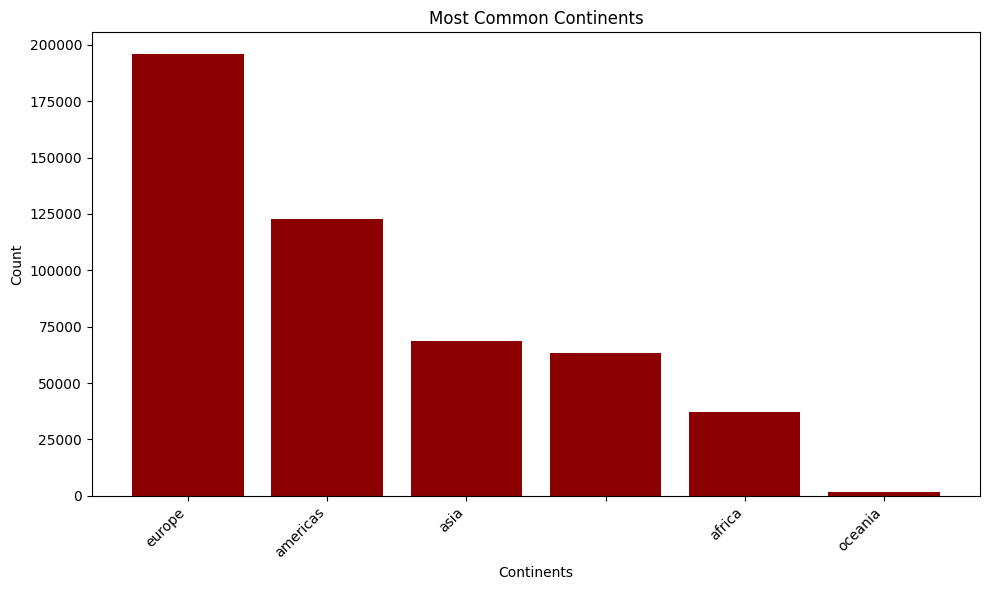

In [50]:
### Bar Graph Comparing Top 10 Regions before Data Cleaning
top_continents = list(zip(*Counter(working_continents_final).most_common()))
print(top_continents)
plt.figure(figsize=(10, 6))
plt.bar(top_continents[0], top_continents[1], color='darkred')
plt.xlabel('Continents')
plt.ylabel('Count')
plt.title('Most Common Continents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Create new columns for cleaned datasets


Nested lists for region, culture, nationality, and country are added to the dataframe.

In [51]:
met_geo_df["region_new"] = region_cc_final
met_geo_df["culture_new"] = culture_cc_final
met_geo_df["nationality_new"] = artist_natl_final_supp_2
met_geo_df["country_new"] = country_cc_final_supp_2
met_geo_df["continents"] = continent_col

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\2322492178.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df["region_new"] = region_cc_final
C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\2322492178.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df["culture_new"] = culture_cc_final
C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\2322492178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

For visualization purposes, the first item in each nested list within the lists of regions, cultures, artist nationalities, and countries will be selected and added to new columns.

In [52]:
met_geo_df['region_new_single'] = met_geo_df['region_new'].str[0]
met_geo_df['culture_new_single'] = met_geo_df['culture_new'].str[0]
met_geo_df['nationality_new_single'] = met_geo_df['nationality_new'].str[0]
met_geo_df['country_new_single'] = met_geo_df['country_new'].str[0]
met_geo_df["continents_single"] = met_geo_df["continents"].str[0]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\3836048839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df['region_new_single'] = met_geo_df['region_new'].str[0]
C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\3836048839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_geo_df['culture_new_single'] = met_geo_df['culture_new'].str[0]
C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\3836048839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

## Clean Data by Continent

Examining representation of individual cultures across continents.

### Americas

In [53]:
# Filter 'met_geo_df' where 'continents' == 'americas'

americas_met_df = met_geo_df[met_geo_df['continents_single'] == 'americas']

#### Americas: Artist Nationalities

In [54]:
# Flatten nested list of country copy lists
americas_natl_list = list(chain.from_iterable(americas_met_df["nationality_new"]))

# Count instances of each unique value
unique_americas_natl = Counter(americas_natl_list).most_common()

# print values & counts
print(len(unique_americas_natl))
print()
for key, value in unique_americas_natl:
    print(f"{key} - {value}")

63

american - 106759
mexican - 3305
peruvian - 2590
german - 1540
french - 637
canadian - 539
hungarian - 484
italian - 299
austrian - 266
cuban - 257
japanese - 166
greek - 166
lithuanian - 152
british - 147
colombian - 139
costa rican - 114
argentinian - 111
brazilian - 99
armenian - 82
danish - 71
uruguayan - 61
guatemalan - 55
bolivian - 52
panamanian - 39
irish - 35
chilean - 29
venezuelan - 28
chinese - 28
spanish - 24
puerto rican - 23
iranian - 23
ecuadorean - 21
paraguayan - 20
guyanese - 20
haitian - 19
dominican - 12
egyptian - 12
finnish - 10
russian - 9
ukrainian - 8
korean - 8
portuguese - 8
filipino - 5
nicaraguan - 5
saint lucian - 5
greenlandic - 4
jamaican - 3
tunisian - 3
pakistani - 3
turkish - 3
swiss - 2
polish - 2
bahamian - 2
nigerian - 2
bulgarian - 2
malaysian - 2
martinican - 2
honduran - 1
antiguan - 1
iraqi - 1
dutch - 1
indian - 1
czech - 1


In [55]:
# Count instances of each unique value
unique_americas_natl_2 = Counter(americas_met_df["nationality_new_single"]).most_common()

# print values & counts
print(len(unique_americas_natl_2))
print()
for key, value in unique_americas_natl_2:
    print(f"{key} - {value}")

51

american - 106329
nan - 3606
mexican - 3301
peruvian - 2504
canadian - 539
italian - 292
british - 147
colombian - 138
costa rican - 114
argentinian - 111
brazilian - 99
french - 85
uruguayan - 61
guatemalan - 55
bolivian - 52
hungarian - 42
irish - 35
cuban - 32
panamanian - 32
chilean - 29
venezuelan - 28
puerto rican - 23
iranian - 23
german - 22
ecuadorean - 21
paraguayan - 20
guyanese - 20
haitian - 19
dominican - 12
finnish - 10
russian - 9
spanish - 7
austrian - 5
nicaraguan - 5
saint lucian - 5
greenlandic - 4
jamaican - 3
turkish - 3
swiss - 2
japanese - 2
bahamian - 2
nigerian - 2
malaysian - 2
martinican - 2
chinese - 1
honduran - 1
antiguan - 1
danish - 1
iraqi - 1
dutch - 1
czech - 1


#### Americas: Cultures

In [56]:
# Flatten nested list of country copy lists
americas_natl_list = list(chain.from_iterable(americas_met_df["nationality_new"]))

# Count instances of each unique value
unique_americas_natl = Counter(americas_natl_list).most_common()

# print values & counts
print(len(unique_americas_natl))
print()
for key, value in unique_americas_natl:
    print(f"{key} - {value}")

63

american - 106759
mexican - 3305
peruvian - 2590
german - 1540
french - 637
canadian - 539
hungarian - 484
italian - 299
austrian - 266
cuban - 257
japanese - 166
greek - 166
lithuanian - 152
british - 147
colombian - 139
costa rican - 114
argentinian - 111
brazilian - 99
armenian - 82
danish - 71
uruguayan - 61
guatemalan - 55
bolivian - 52
panamanian - 39
irish - 35
chilean - 29
venezuelan - 28
chinese - 28
spanish - 24
puerto rican - 23
iranian - 23
ecuadorean - 21
paraguayan - 20
guyanese - 20
haitian - 19
dominican - 12
egyptian - 12
finnish - 10
russian - 9
ukrainian - 8
korean - 8
portuguese - 8
filipino - 5
nicaraguan - 5
saint lucian - 5
greenlandic - 4
jamaican - 3
tunisian - 3
pakistani - 3
turkish - 3
swiss - 2
polish - 2
bahamian - 2
nigerian - 2
bulgarian - 2
malaysian - 2
martinican - 2
honduran - 1
antiguan - 1
iraqi - 1
dutch - 1
indian - 1
czech - 1


### Isolate a 'final' DF with cleaned colunms for geographic data

This will be merged with materials data for visualization.

In [57]:
met_geo_final_df = met_geo_df[["objectID", "department", "country_new", "country_new_single", "nationality_new", "nationality_new_single", "region_new", "region_new_single", "culture_new", "culture_new_single", "continents", "continents_single"]]

# Data Cleaning Part II: Materials & Other Data

In [58]:
# Create df with data about objects' materials, mediums, and classifications

met_material_df = met_df[["objectID", "department", "objectName", "medium", "classification", "objectEndDate", "accessionYear", "artistGender", "creditLine", "tags"]]

## 'objectName' Column

In [59]:
met_material_df.loc[:, "objectName_cc"] = met_material_df.loc[:, "objectName"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\606253287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_material_df.loc[:, "objectName_cc"] = met_material_df.loc[:, "objectName"]


In [60]:
# Cast country copy column as strings
met_material_df.loc[:, "objectName_cc"] = met_material_df.loc[:, "objectName_cc"].astype(str)

# Set country copy values to lowercase
met_material_df.loc[:, "objectName_cc"] = met_material_df.loc[:, "objectName_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of country copy values
met_material_df.loc[:, "objectName_cc"] = met_material_df.loc[:, "objectName_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [61]:
# Check current objectName values 

met_objectNames = Counter(met_material_df["objectName_cc"]).most_common()

print(f"Unique objectName values: {len(met_objectNames)}")
print()
for key, value in met_objectNames:
    print(f"{key} - {value}")

Unique objectName values: 27407

print - 104334
photograph - 28869
drawing - 26126
book - 13412
kylix fragment - 8943
piece - 8621
fragment - 7198
painting - 5809
negative - 4746
bowl - 3611
vase - 3227
figure - 3041
dress - 2672
baseball card - 2505
baseball card, print - 2463
 - 2410
print ornament & architecture - 2264
plate - 2204
ensemble - 2157
textile fragment - 2152
baseball card, photograph - 2099
books prints ornament & architecture - 2027
dish - 1945
evening dress - 1887
medal - 1883
print; ephemera - 1667
hanging scroll - 1658
panel - 1649
drawing ; ornament and architecture - 1634
drawing ornament & architecture - 1620
hat - 1523
print collection ornament & architecture - 1516
sculpture - 1473
ornament - 1468
bottle - 1446
textile sample - 1410
carte-de-visite - 1288
stereograph - 1277
jar - 1272
sword guard (tsuba) - 1213
vase fragment - 1195
cup - 1188
book ; ornament and architecture - 1170
kylix fragments - 1141
scarab - 1130
plaque - 1111
knife handle (kozuka) - 1088


This column has 2341 missing values. Most common include prints, photographs, drawings, books, and pottery.

## 'medium' Column

In [62]:
met_material_df.loc[:, "medium_cc"] = met_material_df.loc[:, "medium"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\3411270470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_material_df.loc[:, "medium_cc"] = met_material_df.loc[:, "medium"]


In [63]:
# Cast country copy column as strings
met_material_df.loc[:, "medium_cc"] = met_material_df.loc[:, "medium_cc"].astype(str)

# Set country copy values to lowercase
met_material_df.loc[:, "medium_cc"] = met_material_df.loc[:, "medium_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of country copy values
met_material_df.loc[:, "medium_cc"] = met_material_df.loc[:, "medium_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)


In [64]:
# Check current medium values 

met_mediums = Counter(met_material_df["medium_cc"]).most_common()

print(f"Unique medium values: {len(met_mediums)}")
print()
for key, value in met_mediums:
    print(f"{key} - {value}")

Unique medium values: 63958

terracotta - 23352
commercial color lithograph - 19185
etching - 17953
silk - 13330
engraving - 11903
albumen photograph - 10152
gelatin silver print - 10015
 - 7313
bronze - 7248
lithograph - 7159
glass - 6630
cotton - 5482
faience - 4997
silver - 4748
woodcut - 4736
albumen silver print from glass negative - 4731
film negative - 4712
gold - 3930
etching and engraving - 3683
commercial color photolithograph - 3412
oil on canvas - 3396
commercial photolithograph - 3161
wood - 2826
albumen silver print - 2670
wool - 2572
wood engraving - 2463
woodblock print; ink and color on paper - 2443
hard-paste porcelain - 2391
stone - 2163
porcelain - 2089
linen - 2045
ceramic - 1911
limestone - 1840
bobbin lace - 1833
hand-colored etching - 1807
steel - 1739
iron - 1714
ivory - 1699
color lithograph - 1687
[no medium available] - 1662
limestone, paint - 1483
leather - 1463
soft-paste porcelain - 1449
graphite - 1434
earthenware - 1424
commercial lithograph - 1409
pott

This column has 7246 missing values. The most common materials are terracotta, lithographs, etchings, silk, engravings, photographs, bronze, prints, and glass.

## 'classification' Column

In [65]:
# Create second column to clean classfication column

met_material_df.loc[:, "classification_cc"] = met_material_df.loc[:, "classification"]

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\555332460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_material_df.loc[:, "classification_cc"] = met_material_df.loc[:, "classification"]


In [66]:
# Cast country copy column as strings
met_material_df.loc[:, "classification_cc"] = met_material_df.loc[:, "classification_cc"].astype(str)

# Set country copy values to lowercase
met_material_df.loc[:, "classification_cc"] = met_material_df.loc[:, "classification_cc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Strip whitespaces from ends of country copy values
met_material_df.loc[:, "classification_cc"] = met_material_df.loc[:, "classification_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)


In [67]:
# Check current region values 
met_classifications = Counter(met_material_df["classification_cc"]).most_common()

print(f"Unique classification values: {len(met_classifications)}")
print()
for key, value in met_classifications:
    print(f"{key} - {value}")

Unique classification values: 706

prints - 122591
 - 85160
photographs - 38805
drawings - 28518
vases - 21224
books - 20844
ceramics - 11028
textiles-woven - 11016
paintings - 8805
glass - 6097
textiles-laces - 4973
negatives - 4935
textiles-embroidered - 4182
ceramics-porcelain - 4135
metalwork-silver - 3940
sculpture - 3593
ceramics-pottery - 3581
textiles-printed - 2562
metalwork - 2336
jewelry - 2330
textiles - 2093
gold and silver - 1957
textiles-trimmings - 1950
metal-ornaments - 1890
bronzes - 1825
stucco - 1741
terracottas - 1698
jade - 1664
gems - 1607
albums - 1603
wood-sculpture - 1586
woodwork-furniture - 1472
medals and plaquettes - 1460
textiles-velvets - 1425
codices - 1313
metalwork-iron - 1245
sword furniture-tsuba - 1242
sword furniture-kozuka - 1117
ceramics-containers - 1098
swords - 1087
coins - 1073
cut paper - 1070
glass-stained - 1016
stone sculpture - 1009
shafted weapons - 954
netsuke - 942
horology - 929
metalwork-gilt bronze - 915
ephemera - 901
lacquer - 8

In [68]:
# Print the 200 most common classifications

for key, value in met_classifications[:200]:
    print(f"{key} - {value}")

prints - 122591
 - 85160
photographs - 38805
drawings - 28518
vases - 21224
books - 20844
ceramics - 11028
textiles-woven - 11016
paintings - 8805
glass - 6097
textiles-laces - 4973
negatives - 4935
textiles-embroidered - 4182
ceramics-porcelain - 4135
metalwork-silver - 3940
sculpture - 3593
ceramics-pottery - 3581
textiles-printed - 2562
metalwork - 2336
jewelry - 2330
textiles - 2093
gold and silver - 1957
textiles-trimmings - 1950
metal-ornaments - 1890
bronzes - 1825
stucco - 1741
terracottas - 1698
jade - 1664
gems - 1607
albums - 1603
wood-sculpture - 1586
woodwork-furniture - 1472
medals and plaquettes - 1460
textiles-velvets - 1425
codices - 1313
metalwork-iron - 1245
sword furniture-tsuba - 1242
sword furniture-kozuka - 1117
ceramics-containers - 1098
swords - 1087
coins - 1073
cut paper - 1070
glass-stained - 1016
stone sculpture - 1009
shafted weapons - 954
netsuke - 942
horology - 929
metalwork-gilt bronze - 915
ephemera - 901
lacquer - 847
daggers - 826
glass-vessels - 81

## OBJECT ACCESSION YEARS

In [69]:
# Copy accession year column, remove MM-DD data, and replace empty values with NAN

met_material_df.loc[:, "accessionYear_cc"] = met_material_df.loc[:, "accessionYear"].astype(str).apply(lambda x: re.sub(r'-.+', '', x))
met_material_df.loc[:, "accessionYear_cc"] = met_material_df.loc[:, "accessionYear_cc"].replace("", "nan")
# met_material_df.loc[:, "accessionYear_cc"] = pd.to_numeric(met_material_df.loc[:, "accessionYear_cc"], downcast="integer", errors="coerce")

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\2010100958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_material_df.loc[:, "accessionYear_cc"] = met_material_df.loc[:, "accessionYear"].astype(str).apply(lambda x: re.sub(r'-.+', '', x))


In [70]:
# Count and list all object end dates
met_accession_yrs = Counter(met_material_df["accessionYear_cc"]).most_common()

print(f"Accession Years: {len(met_accession_yrs)}")
print()
for key, value in met_accession_yrs:
    print(f"{key} - {value}")

Accession Years: 156

1963 - 42084
2011 - 18625
1917 - 12609
1994 - 9392
2009 - 9379
1936 - 9190
1926 - 7378
1953 - 7296
1923 - 6858
1941 - 6766
1959 - 6212
1951 - 6076
1975 - 5700
1920 - 5646
1930 - 5507
1910 - 5485
1949 - 5471
1948 - 5426
1914 - 5405
2005 - 5284
1874 - 5202
1979 - 5112
1946 - 5016
1909 - 4925
1929 - 4921
1908 - 4875
1978 - 4866
1962 - 4799
1933 - 4745
1924 - 4593
1922 - 4536
1957 - 4517
1943 - 4468
1964 - 4292
1967 - 4073
1950 - 3956
1925 - 3933
1889 - 3926
nan - 3917
1921 - 3782
1932 - 3722
1960 - 3673
1986 - 3636
1984 - 3576
1970 - 3485
1927 - 3471
1981 - 3394
1987 - 3353
1999 - 3294
1942 - 3290
1907 - 3283
1954 - 3243
1952 - 3239
2018 - 3090
1966 - 2957
1958 - 2933
2012 - 2906
2002 - 2902
1985 - 2884
1928 - 2869
1974 - 2819
1911 - 2816
1896 - 2788
1972 - 2782
1961 - 2759
1977 - 2745
1991 - 2743
1913 - 2690
2015 - 2681
1965 - 2633
1955 - 2621
2001 - 2617
1938 - 2613
1982 - 2612
1937 - 2564
1940 - 2564
1939 - 2544
2019 - 2522
1968 - 2506
2016 - 2473
1947 - 2469
1976

## OBJECT END DATES

In [71]:
# Copy object end date column
met_material_df.loc[:, "objectEndDate_cc"] = met_material_df.loc[:, "objectEndDate"]

# Cast object end date copy column as strings
met_material_df.loc[:, "objectEndDate_cc"] = met_material_df.loc[:, "objectEndDate_cc"].astype(str)

# Set remove all non-numeric characters except hyphens from object end dates
met_material_df.loc[:, "objectEndDate_cc"] = met_material_df.loc[:, "objectEndDate_cc"].apply(lambda x: re.sub(r'[^-\d]', '', x))

# Strip whitespaces from ends of object end date copy values
met_material_df.loc[:, "objectEndDate_cc"] = met_material_df.loc[:, "objectEndDate_cc"].apply(lambda x: x.strip() if isinstance(x, str) else x)

# Convert column to numeric
met_material_df.loc[:, "objectEndDate_cc"] = pd.to_numeric(met_material_df["objectEndDate_cc"], downcast='integer', errors="coerce")

C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\660305987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  met_material_df.loc[:, "objectEndDate_cc"] = met_material_df.loc[:, "objectEndDate"]
C:\Users\reedc\AppData\Local\Temp\ipykernel_27312\660305987.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1853' '1901' '1927' ... '1960' '1960' '1960']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  met_material_df.loc[:, "objectEndDate_cc"] = met_material_df.loc[:, "objectEndDate_cc"].astype(str)


In [72]:
# Count and list all object end dates
met_objectEndDates = Counter(met_material_df["objectEndDate_cc"]).most_common()

print(f"Unique Object Creation Dates: {len(met_objectEndDates)}")
print()
for key, value in met_objectEndDates:
    print(f"{key} - {value}")

Unique Object Creation Dates: 2040

1899 - 20691
1900 - 13766
1799 - 11490
-450 - 9756
1889 - 7153
1890 - 6416
1699 - 5248
1888 - 5081
1800 - 4886
-400 - 4660
-300 - 4634
1930 - 4318
2000 - 4137
1599 - 3920
1911 - 3490
1939 - 3426
1935 - 3238
1910 - 3164
1600 - 3074
1925 - 3014
-1295 - 2915
1850 - 2701
1875 - 2661
1887 - 2547
1950 - 2521
1891 - 2480
1959 - 2404
1870 - 2379
1499 - 2333
699 - 2327
1700 - 2317
1869 - 2291
1940 - 2285
1943 - 2255
1865 - 2247
1815 - 2239
1920 - 2230
1929 - 2180
1892 - 2077
1795 - 1995
1879 - 1989
1955 - 1980
1300 - 1975
1895 - 1960
1969 - 1942
1999 - 1916
330 - 1850
1933 - 1830
-1640 - 1817
1860 - 1799
-1390 - 1726
1912 - 1717
1949 - 1707
1199 - 1699
1905 - 1696
1790 - 1672
1770 - 1649
1780 - 1621
1936 - 1613
1880 - 1611
1775 - 1609
1960 - 1605
1859 - 1604
-30 - 1572
1830 - 1563
1885 - 1560
-1070 - 1543
1765 - 1541
1840 - 1516
999 - 1516
1825 - 1502
1915 - 1472
1855 - 1458
1922 - 1431
1550 - 1424
1957 - 1371
1500 - 1369
1750 - 1358
1974 - 1351
1931 - 1315
1

## Combine Cleaned Dataframes Containing Geographic and Material Data

In [73]:
met_material_final_df = met_material_df[["objectID", "department", "objectName_cc", "medium_cc", "classification_cc","objectEndDate_cc", "accessionYear_cc", "artistGender", "creditLine", "tags"]]

In [74]:
met_df_clean = pd.merge(met_geo_final_df, met_material_final_df, on=["objectID", "department"], how="outer")

In [75]:
met_df_clean.head()

objectID         department      country_new country_new_single  \
0         1  The American Wing  [united states]      united states   
1         2  The American Wing  [united states]      united states   
2         3  The American Wing               []                      
3         4  The American Wing               []                      
4         5  The American Wing               []                      

  nationality_new nationality_new_single region_new region_new_single  \
0      [american]               american         []                     
1      [american]               american         []                     
2              []                                []                     
3              []                                []                     
4              []                                []                     

  culture_new culture_new_single  continents continents_single objectName_cc  \
0          []                     [americas]          americas          coin   
1          []                     [americas]          americas          coin   
2          []                             []                            coin   
3          []                             []                            coin   
4          []                             []                            coin   

  medium_cc classification_cc objectEndDate_cc accessionYear_cc artistGender  \
0      gold                               1853             1979                
1      gold                               1901             1980                
2      gold                               1927             1967                
3      gold                               1927             1967                
4      gold                               1927             1967                

                           creditLine  tags  
0  Gift of Heinz L. Stoppelmann, 1979  None  
1  Gift of Heinz L. Stoppelmann, 1980  None  
2    Gift of C. Ruxton Love Jr., 1967  None  
3    Gift of C. Ruxton Love Jr., 1967  None  
4    Gift of C. Ruxton Love Jr., 1967  None

# Data Cleaning Part III: Export to CSV

Export the concatenated dataframe of cleaned data to a CSV file for analysis and visualization.

In [76]:
met_df_clean.to_csv('../../data/met/csv/met_data_cleaned.csv', index=False)

## Appendix: Troubleshooting stubborn typos 

Manually search parent df when anomalies occur during cleaning. Below is an example / test case:

In [77]:
# search_term = met_geo_df.loc[met_geo_df["artistNationality"].str.contains(r"buganda", case=False)]

# search_filter = search_term["artistNationality"].to_list()

# for s in search_filter:
#     print(s)